In [25]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from DataQualityCheck import DataQualityChecks, DataCleaning, missing_data_analysis   
import statsmodels.api as sm

In [26]:
df = pd.read_csv('CreditCardFraud_updated.csv')
df.head()

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


=== Basic info ===
=== Data Quality Report ===

1. Basic Information:
Number of rows: 786363
Number of columns: 30

2. No duplicate columns found.

3. Missing Data Analysis:
                     Missing Values  Percentage
acqCountry                     4562    0.580139
merchantCountryCode             724    0.092069
posEntryMode                   4054    0.515538
posConditionCode                409    0.052012
transactionType                 698    0.088763
echoBuffer                   786363  100.000000
merchantCity                 786363  100.000000
merchantState                786363  100.000000
merchantZip                  786363  100.000000
posOnPremises                786363  100.000000
recurringAuthInd             786363  100.000000

4. Columns with entirely missing data: ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']

5. Data Types:
Unnamed: 0                    int64
accountNumber                 int64
customerId            

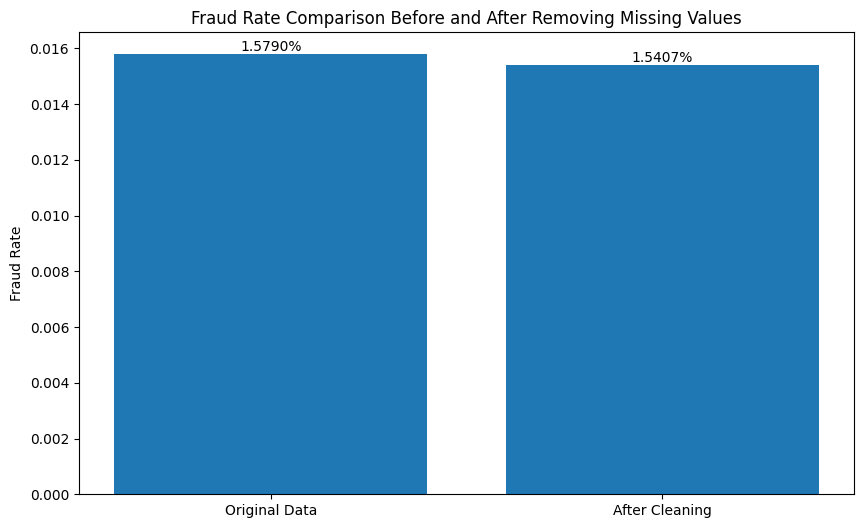

In [27]:

# Extracting info
df = pd.read_csv('CreditCardFraud_updated.csv')

# 1. Basic info
print("=== Basic info ===")
quality_checker = DataQualityChecks(df)
quality_results = quality_checker.perform_data_quality_checks() 


# Run missing data analysis
missing_data_analysis(df)


In [28]:
# Define function to detect and remove outliers for each numerical column
def detect_and_handle_outliers(df, column, plot_data=None):
    # Skip non-numeric columns
    if df[column].dtype not in ['int64', 'float64']:
        return df, None
    
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Store outlier info for plotting if requested
    if plot_data is not None and not outliers.empty:
        plot_data[column] = {
            'data': df[column],
            'outliers': outliers[column],
            'bounds': (lower_bound, upper_bound)
        }
    
    # Remove outliers
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_clean, outliers

# Initialize variables to track changes
original_fraud_rate = df['isFraud'].mean()
columns_with_outliers = {}
plot_data = {}

# Process each numeric column
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col != 'isFraud']

print("=== Outlier Detection and Removal ===")
print(f"Original fraud rate: {original_fraud_rate:.4f}")

# Create a copy of the original dataframe
df_clean = df.copy()

# Process each column
# After investigating the plot and the real meaning of the data, I found that the outliers of the creditlimit and transactionamount should not be removed.
for column in numeric_columns:
    if column == 'creditLimit' or column == 'transactionAmount' or column == 'availableMoney' or column == 'posEntryMode' or column == 'posConditionCode' or column == 'currentBalance':
        continue
    else:
        temp_df, outliers = detect_and_handle_outliers(df_clean, column, plot_data)
        
        if outliers is not None and not outliers.empty:
            # Calculate fraud rate before and after
            before_rate = df_clean['isFraud'].mean()
            after_rate = temp_df['isFraud'].mean()
            change = abs(after_rate - before_rate) / before_rate * 100
            
            # Only update if significant change or first outlier removal
            if change > 5 or len(columns_with_outliers) == 0:
                columns_with_outliers[column] = {
                    'outliers_count': len(outliers),
                    'before_rate': before_rate,
                    'after_rate': after_rate,
                    'change_percent': change
                }
                df_clean = temp_df

# Report on columns with significant changes
if columns_with_outliers:
    print("\nColumns with significant fraud rate changes after outlier removal:")
    for col, info in columns_with_outliers.items():
        print(f"{col}: {info['outliers_count']} outliers removed, fraud rate changed from {info['before_rate']:.4f} to {info['after_rate']:.4f} ({info['change_percent']:.2f}% change)")

# Plot outliers for columns with significant changes
if plot_data:
    # Determine number of plots needed
    n_plots = len(plot_data)
    if n_plots > 0:
        fig, axes = plt.subplots(n_plots, 1, figsize=(10, 4 * n_plots))
        if n_plots == 1:
            axes = [axes]  # Make it iterable for single plot
            
        for i, (col, info) in enumerate(plot_data.items()):
            # Create boxplot
            sns.boxplot(x=info['data'], ax=axes[i])
            axes[i].set_title(f'Distribution of {col} with Outliers')
            
            # Mark outlier bounds
            lower, upper = info['bounds']
            axes[i].axvline(x=lower, color='r', linestyle='--', label=f'Lower bound: {lower:.2f}')
            axes[i].axvline(x=upper, color='r', linestyle='--', label=f'Upper bound: {upper:.2f}')
            axes[i].legend()
            
        plt.tight_layout()
        plt.savefig('outliers_boxplots.png', bbox_inches='tight', dpi=300)
        plt.show()

print(f"\nFinal fraud rate after outlier removal: {df_clean['isFraud'].mean():.4f}")
print(f"Total rows before: {len(df)}, after: {len(df_clean)}, removed: {len(df) - len(df_clean)}")


=== Outlier Detection and Removal ===
Original fraud rate: 0.0158

Final fraud rate after outlier removal: 0.0158
Total rows before: 786363, after: 786363, removed: 0


Converting date columns to datetime format...

Data types after conversion:
transactionDateTime: datetime64[ns]
currentExpDate: datetime64[ns]
accountOpenDate: datetime64[ns]
dateOfLastAddressChange: datetime64[ns]


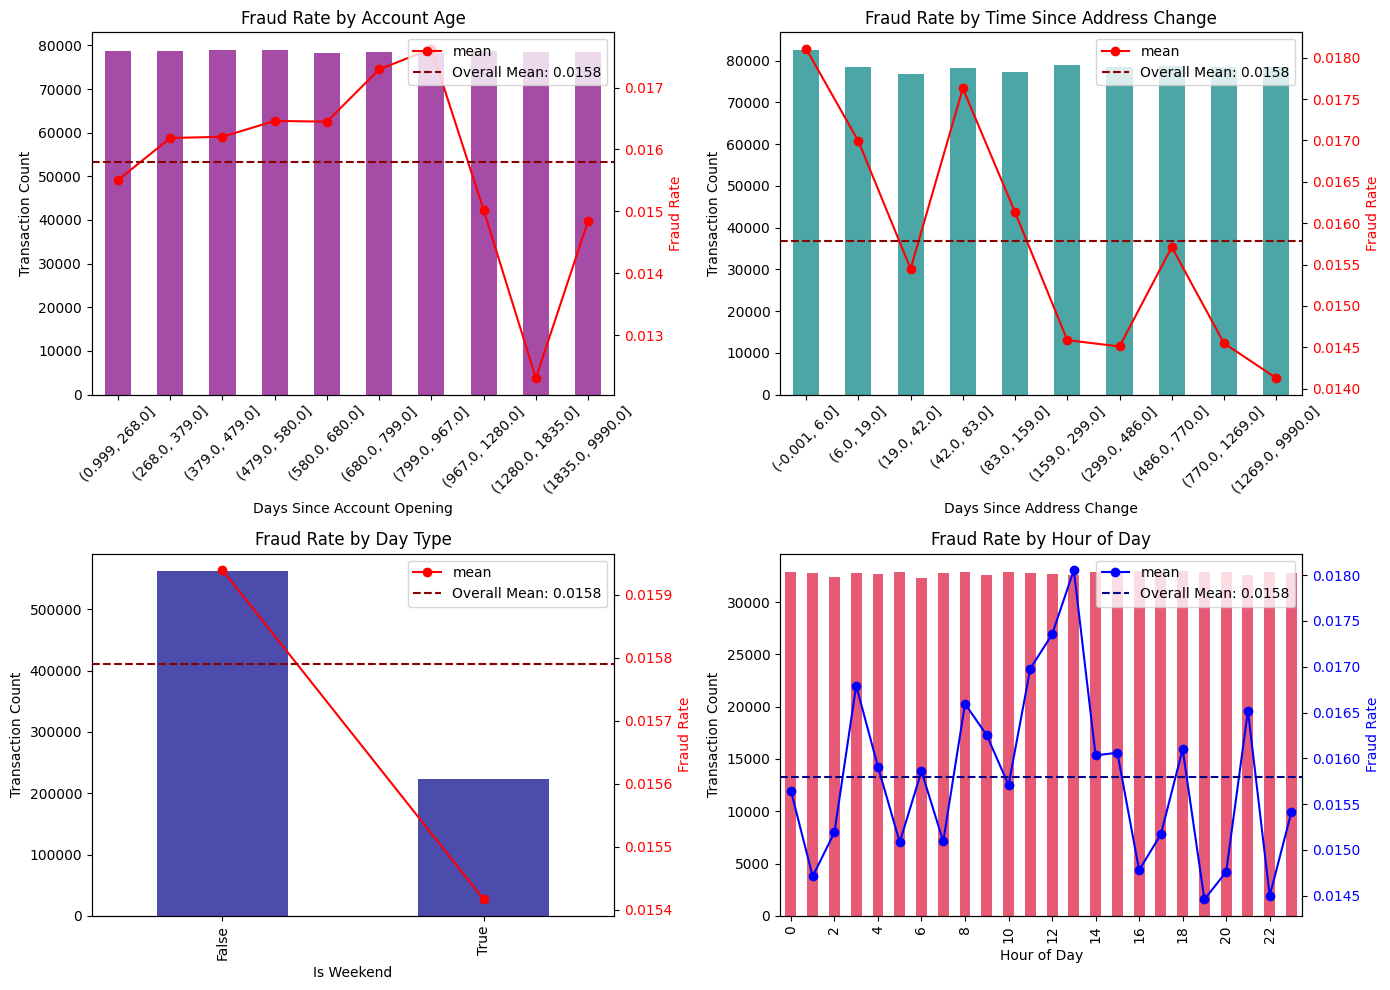

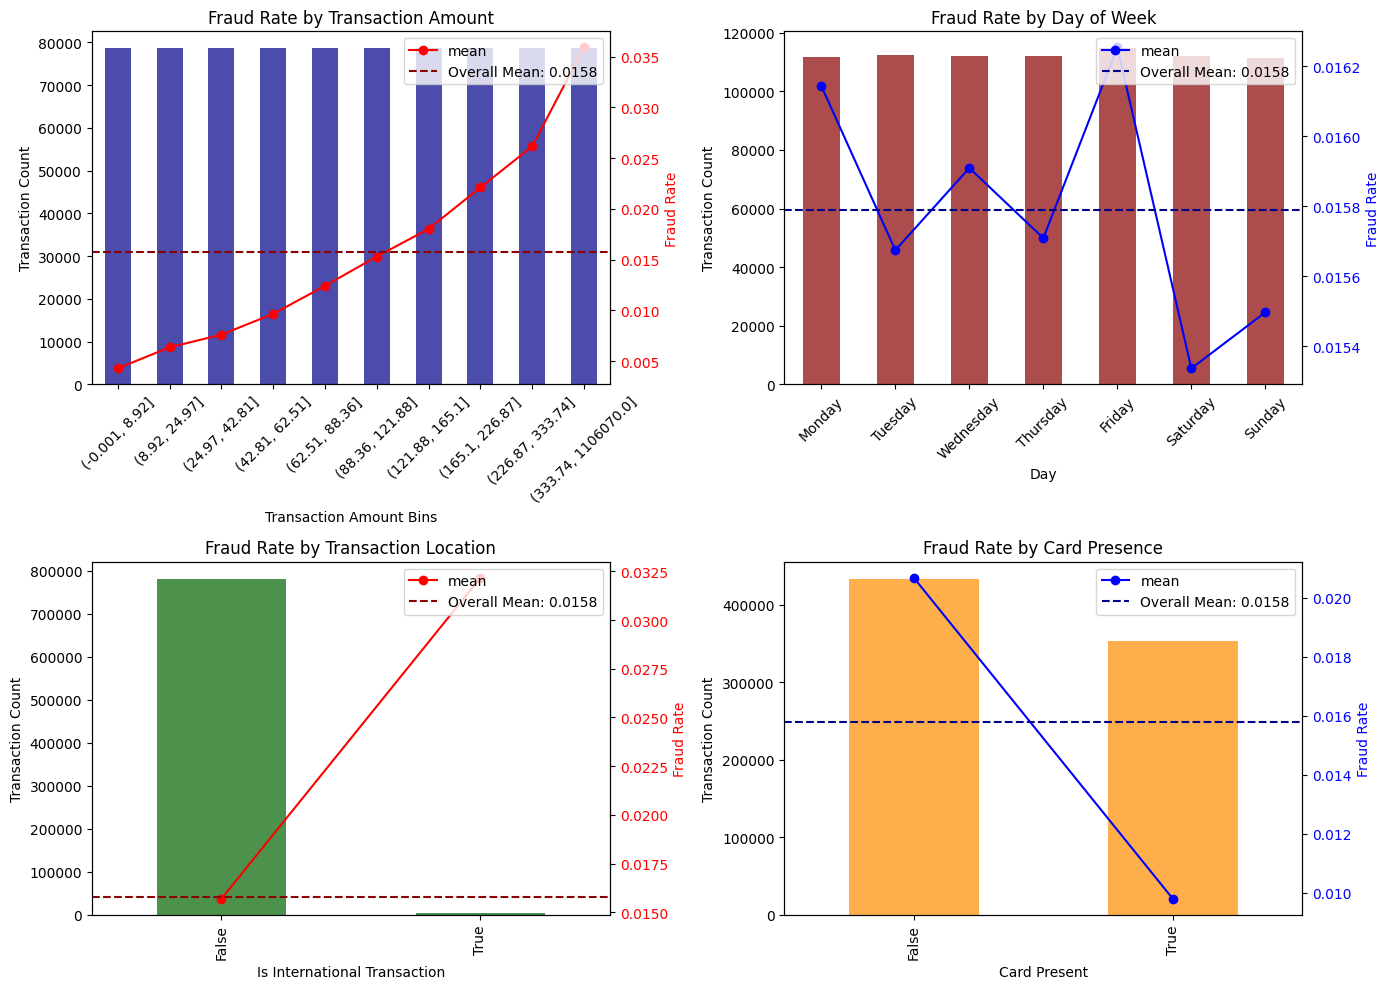

Date conversion complete and data saved.


In [66]:
# Convert date columns to datetime format
print("Converting date columns to datetime format...")

# List of date columns to convert
date_columns = ['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']
df_clean_copy = df_clean.copy()

# Convert date columns to datetime format
for column in date_columns:
    if column in df_clean_copy.columns:
        try:
            df_clean_copy[column] = pd.to_datetime(df_clean_copy[column])
        except Exception:
            print(f"Could not convert {column} automatically. Checking format...")
            # Display a sample to understand the format
            print(f"Sample values for {column}: {df_clean_copy[column].head().tolist()}")
            
            # Try common date formats
            try:
                df_clean_copy[column] = pd.to_datetime(df_clean_copy[column], format='%Y-%m-%d')
            except Exception:
                try:
                    df_clean_copy[column] = pd.to_datetime(df_clean_copy[column], errors='coerce')
                    print(f"Converted {column} with some errors (NaT values may be present)")
                except Exception:
                    print(f"Failed to convert {column} to datetime")

# Check the data types after conversion
print("\nData types after conversion:")
for column in date_columns:
    if column in df_clean_copy.columns:
        print(f"{column}: {df_clean_copy[column].dtype}")

# Create time-related features for fraud pattern analysis
df_clean_copy['transaction_time_after_open'] = df_clean_copy['transactionDateTime'] - df_clean_copy['accountOpenDate']
df_clean_copy['transaction_time_after_last_address_change'] = df_clean_copy['transactionDateTime'] - df_clean_copy['dateOfLastAddressChange']
df_clean_copy['transaction_time_after_current_exp_date'] = df_clean_copy['transactionDateTime'] - df_clean_copy['currentExpDate']
df_clean_copy['is_weekend'] = df_clean_copy['transactionDateTime'].dt.dayofweek.isin([5, 6])
df_clean_copy['transaction_hour'] = df_clean_copy['transactionDateTime'].dt.hour
df_clean_copy['transaction_day'] = df_clean_copy['transactionDateTime'].dt.day_name()

# Convert timedeltas to days for better visualization
df_clean_copy['days_since_account_open'] = df_clean_copy['transaction_time_after_open'].dt.days
df_clean_copy['days_since_address_change'] = df_clean_copy['transaction_time_after_last_address_change'].dt.days

# Create bins for analysis
df_clean_copy['account_age_bin'] = pd.qcut(df_clean_copy['days_since_account_open'], 10, duplicates='drop')
df_clean_copy['address_change_bin'] = pd.qcut(df_clean_copy['days_since_address_change'], 10, duplicates='drop')
df_clean_copy['amount_bin'] = pd.qcut(df_clean_copy['transactionAmount'], 10, duplicates='drop')

# Create additional features for analysis
df_clean_copy['cvv_match'] = df_clean_copy['cardCVV'] == df_clean_copy['enteredCVV']
df_clean_copy['available_money_ratio'] = df_clean_copy['availableMoney'] / df_clean_copy['creditLimit']
df_clean_copy['is_international'] = df_clean_copy['merchantCountryCode'] != df_clean_copy['acqCountry']

# Aggregate data for plotting
account_age_fraud = df_clean_copy.groupby('account_age_bin')['isFraud'].agg(['count', 'mean'])
address_change_fraud = df_clean_copy.groupby('address_change_bin')['isFraud'].agg(['count', 'mean'])
weekend_fraud = df_clean_copy.groupby('is_weekend')['isFraud'].agg(['count', 'mean'])
hour_fraud = df_clean_copy.groupby('transaction_hour')['isFraud'].agg(['count', 'mean'])
amount_fraud = df_clean_copy.groupby('amount_bin')['isFraud'].agg(['count', 'mean'])
cvv_fraud = df_clean_copy.groupby('cvv_match')['isFraud'].agg(['count', 'mean'])
intl_fraud = df_clean_copy.groupby('is_international')['isFraud'].agg(['count', 'mean'])
card_presence_fraud = df_clean_copy.groupby('cardPresent')['isFraud'].agg(['count', 'mean'])
hourly_fraud = df_clean_copy.groupby('transaction_hour')['isFraud'].agg(['count', 'sum', 'mean'])
daily_fraud = df_clean_copy.groupby('transaction_day')['isFraud'].agg(['count', 'mean'])
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_fraud = daily_fraud.reindex(days_order)

# Plot time-related features and fraud rate
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Days since account opening vs Fraud Rate
ax1 = axes[0, 0]
account_age_fraud['count'].plot(kind='bar', ax=ax1, color='purple', alpha=0.7)
ax1.set_title('Fraud Rate by Account Age')
ax1.set_xlabel('Days Since Account Opening')
ax1.set_ylabel('Transaction Count')
ax1.tick_params(axis='x', rotation=45)

# Add mean fraud rate line on secondary y-axis
ax1_twin = ax1.twinx()
account_age_fraud['mean'].plot(kind='line', ax=ax1_twin, color='red', marker='o')
ax1_twin.set_ylabel('Fraud Rate', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1_twin.axhline(y=df_clean_copy['isFraud'].mean(), color='darkred', linestyle='--', 
                label=f'Overall Mean: {df_clean_copy["isFraud"].mean():.4f}')
ax1_twin.legend(loc='upper right')

# Plot 2: Days since address change vs Fraud Rate
ax2 = axes[0, 1]
address_change_fraud['count'].plot(kind='bar', ax=ax2, color='teal', alpha=0.7)
ax2.set_title('Fraud Rate by Time Since Address Change')
ax2.set_xlabel('Days Since Address Change')
ax2.set_ylabel('Transaction Count')
ax2.tick_params(axis='x', rotation=45)

# Add mean fraud rate line on secondary y-axis
ax2_twin = ax2.twinx()
address_change_fraud['mean'].plot(kind='line', ax=ax2_twin, color='red', marker='o')
ax2_twin.set_ylabel('Fraud Rate', color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2_twin.axhline(y=df_clean_copy['isFraud'].mean(), color='darkred', linestyle='--', 
                label=f'Overall Mean: {df_clean_copy["isFraud"].mean():.4f}')
ax2_twin.legend(loc='upper right')

# Plot 3: Weekend vs Weekday Fraud Rate
ax3 = axes[1, 0]
weekend_fraud['count'].plot(kind='bar', ax=ax3, color='darkblue', alpha=0.7)
ax3.set_title('Fraud Rate by Day Type')
ax3.set_xlabel('Is Weekend')
ax3.set_ylabel('Transaction Count')

# Add mean fraud rate line on secondary y-axis
ax3_twin = ax3.twinx()
weekend_fraud['mean'].plot(kind='line', ax=ax3_twin, color='red', marker='o')
ax3_twin.set_ylabel('Fraud Rate', color='red')
ax3_twin.tick_params(axis='y', labelcolor='red')
ax3_twin.axhline(y=df_clean_copy['isFraud'].mean(), color='darkred', linestyle='--', 
                label=f'Overall Mean: {df_clean_copy["isFraud"].mean():.4f}')
ax3_twin.legend(loc='upper right')

# Plot 4: Hour of day vs Fraud Rate
ax4 = axes[1, 1]
hour_fraud['count'].plot(kind='bar', ax=ax4, color='crimson', alpha=0.7)
ax4.set_title('Fraud Rate by Hour of Day')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Transaction Count')
ax4.set_xticks(range(0, 24, 2))

# Add mean fraud rate line on secondary y-axis
ax4_twin = ax4.twinx()
hour_fraud['mean'].plot(kind='line', ax=ax4_twin, color='blue', marker='o')
ax4_twin.set_ylabel('Fraud Rate', color='blue')
ax4_twin.tick_params(axis='y', labelcolor='blue')
ax4_twin.axhline(y=df_clean_copy['isFraud'].mean(), color='darkblue', linestyle='--', 
                label=f'Overall Mean: {df_clean_copy["isFraud"].mean():.4f}')
ax4_twin.legend(loc='upper right')

plt.tight_layout()
plt.savefig('time_related_fraud_patterns.png', bbox_inches='tight', dpi=300)
plt.show()

# Create plots to visualize relationships with fraud
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Transaction Amount vs Fraud Rate
ax1 = axes[0, 0]
amount_fraud['count'].plot(kind='bar', ax=ax1, color='darkblue', alpha=0.7)
ax1.set_title('Fraud Rate by Transaction Amount')
ax1.set_xlabel('Transaction Amount Bins')
ax1.set_ylabel('Transaction Count')
ax1.tick_params(axis='x', rotation=45)

# Add mean fraud rate line on secondary y-axis
ax1_twin = ax1.twinx()
amount_fraud['mean'].plot(kind='line', ax=ax1_twin, color='red', marker='o')
ax1_twin.set_ylabel('Fraud Rate', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1_twin.axhline(y=df_clean_copy['isFraud'].mean(), color='darkred', linestyle='--', 
                label=f'Overall Mean: {df_clean_copy["isFraud"].mean():.4f}')
ax1_twin.legend(loc='upper right')

# Plot fraud rate by day of week
ax2 = axes[0, 1]
daily_fraud['count'].plot(kind='bar', ax=ax2, color='darkred', alpha=0.7)
ax2.set_title('Fraud Rate by Day of Week')
ax2.set_xlabel('Day')
ax2.set_ylabel('Transaction Count')
ax2.tick_params(axis='x', rotation=45)

# Add mean fraud rate line on secondary y-axis
ax2_twin = ax2.twinx()
daily_fraud['mean'].plot(kind='line', ax=ax2_twin, color='blue', marker='o')
ax2_twin.set_ylabel('Fraud Rate', color='blue')
ax2_twin.tick_params(axis='y', labelcolor='blue')
ax2_twin.axhline(y=df_clean_copy['isFraud'].mean(), color='darkblue', linestyle='--', 
                label=f'Overall Mean: {df_clean_copy["isFraud"].mean():.4f}')
ax2_twin.legend(loc='upper right')



# # Plot 2: CVV Match vs Fraud Rate
# ax2 = axes[0, 1]
# cvv_fraud['count'].plot(kind='bar', ax=ax2, color='darkred', alpha=0.7)
# ax2.set_title('Fraud Rate by CVV Match')
# ax2.set_xlabel('CVV Matches')
# ax2.set_ylabel('Transaction Count')

# # Add mean fraud rate line on secondary y-axis
# ax2_twin = ax2.twinx()
# cvv_fraud['mean'].plot(kind='line', ax=ax2_twin, color='blue', marker='o')
# ax2_twin.set_ylabel('Fraud Rate', color='blue')
# ax2_twin.tick_params(axis='y', labelcolor='blue')
# ax2_twin.axhline(y=df_clean_copy['isFraud'].mean(), color='darkblue', linestyle='--', 
#                 label=f'Overall Mean: {df_clean_copy["isFraud"].mean():.4f}')
# ax2_twin.legend(loc='upper right')

# Plot 3: International vs Domestic Transactions
ax3 = axes[1, 0]
intl_fraud['count'].plot(kind='bar', ax=ax3, color='darkgreen', alpha=0.7)
ax3.set_title('Fraud Rate by Transaction Location')
ax3.set_xlabel('Is International Transaction')
ax3.set_ylabel('Transaction Count')

# Add mean fraud rate line on secondary y-axis
ax3_twin = ax3.twinx()
intl_fraud['mean'].plot(kind='line', ax=ax3_twin, color='red', marker='o')
ax3_twin.set_ylabel('Fraud Rate', color='red')
ax3_twin.tick_params(axis='y', labelcolor='red')
ax3_twin.axhline(y=df_clean_copy['isFraud'].mean(), color='darkred', linestyle='--', 
                label=f'Overall Mean: {df_clean_copy["isFraud"].mean():.4f}')
ax3_twin.legend(loc='upper right')

# Plot 4: Card Present vs Not Present
ax4 = axes[1, 1]
card_presence_fraud['count'].plot(kind='bar', ax=ax4, color='darkorange', alpha=0.7)
ax4.set_title('Fraud Rate by Card Presence')
ax4.set_xlabel('Card Present')
ax4.set_ylabel('Transaction Count')

# Add mean fraud rate line on secondary y-axis
ax4_twin = ax4.twinx()
card_presence_fraud['mean'].plot(kind='line', ax=ax4_twin, color='blue', marker='o')
ax4_twin.set_ylabel('Fraud Rate', color='blue')
ax4_twin.tick_params(axis='y', labelcolor='blue')
ax4_twin.axhline(y=df_clean_copy['isFraud'].mean(), color='darkblue', linestyle='--', 
                label=f'Overall Mean: {df_clean_copy["isFraud"].mean():.4f}')
ax4_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()

# # Create compact plot to analyze fraud patterns by time
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# # Plot fraud rate by hour
# ax1 = ax[0]
# hourly_fraud['count'].plot(kind='bar', ax=ax1, color='darkblue', alpha=0.7)
# ax1.set_title('Fraud Rate by Hour of Day')
# ax1.set_xlabel('Hour')
# ax1.set_ylabel('Transaction Count')
# ax1.set_xticks(range(0, 24, 2))
# ax1.grid(linestyle='--', alpha=0.7)

# # Add mean fraud rate line on secondary y-axis
# ax1_twin = ax1.twinx()
# hourly_fraud['mean'].plot(kind='line', ax=ax1_twin, color='red', marker='o')
# ax1_twin.set_ylabel('Fraud Rate', color='red')
# ax1_twin.tick_params(axis='y', labelcolor='red')
# ax1_twin.axhline(y=df_clean_copy['isFraud'].mean(), color='darkred', linestyle='--', 
#                 label=f'Overall Mean: {df_clean_copy["isFraud"].mean():.4f}')
# ax1_twin.legend(loc='upper right')

# Save processed data
df_clean_copy.to_csv('processed_data_with_time_features.csv')
print("Date conversion complete and data saved.")


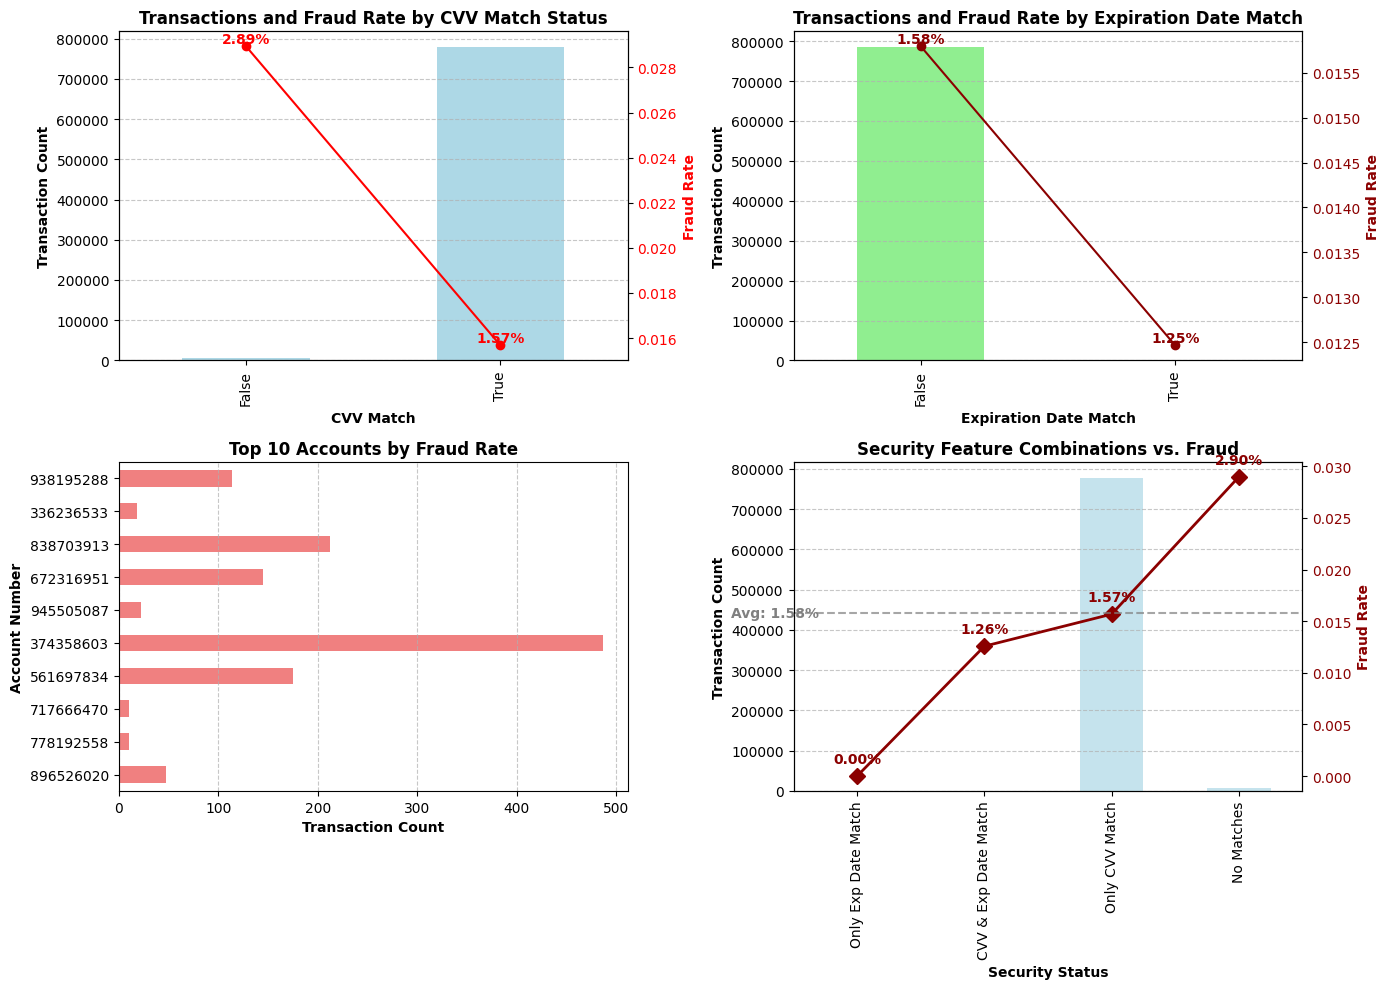

In [38]:
# Analyze the relationship between card security features and fraud
# First, ensure card-related columns are properly formatted as strings
#fill the cardLast4Digits with leading zeros to ensure all values have 4 digits

df_clean['cardCVV'] = df_clean['cardCVV'].astype(str)
df_clean['enteredCVV'] = df_clean['enteredCVV'].astype(str)
df_clean['cardLast4Digits'] = df_clean['cardLast4Digits'].astype(str).str.zfill(4)

# Create a new feature: CVV match (whether entered CVV matches the card CVV)
df_clean['cvv_match'] = df_clean['cardCVV'] == df_clean['enteredCVV']

# Calculate fraud rates by CVV match status
cvv_match_counts = df_clean.groupby('cvv_match')['isFraud'].count()
cvv_match_fraud = df_clean.groupby('cvv_match')['isFraud'].mean()


# Analyze fraud patterns by card last 4 digits
fraud_by_card = df_clean.groupby('accountNumber')['isFraud'].agg(['count', 'sum', 'mean'])
fraud_by_card.columns = ['Total_Transactions', 'Fraud_Transactions', 'Fraud_Rate']
fraud_by_card = fraud_by_card.sort_values('Fraud_Rate', ascending=False)



# Filter to cards with minimum transaction count for statistical significance
min_transactions = 10
fraud_by_card_filtered = fraud_by_card[fraud_by_card['Total_Transactions'] >= min_transactions]

# Create visualizations for card security features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Fraud rate by CVV match status
ax1 = axes[0, 0]
cvv_match_counts.plot(kind='bar', ax=ax1, color='lightblue')
ax1.set_title('Transactions and Fraud Rate by CVV Match Status', fontsize=12, fontweight='bold')
ax1.set_xlabel('CVV Match', fontweight='bold')
ax1.set_ylabel('Transaction Count', fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.7)


# Add fraud rate line on secondary y-axis
ax1_twin = ax1.twinx()
cvv_match_fraud.plot(kind='line', ax=ax1_twin, color='red', marker='o')
ax1_twin.set_ylabel('Fraud Rate', color='red', fontweight='bold')
ax1_twin.tick_params(axis='y', labelcolor='red')
# Add percentage labels
for i, v in enumerate(cvv_match_fraud):
    ax1_twin.text(i, v, f'{v:.2%}', ha='center', va='bottom', color='red', fontweight='bold')


# Plot 2: Fraud rate by expiration date match status
exp_date_counts = df_clean.groupby('expirationDateKeyInMatch')['isFraud'].count()
exp_date_fraud = df_clean.groupby('expirationDateKeyInMatch')['isFraud'].mean()

ax2 = axes[0, 1]
exp_date_counts.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Transactions and Fraud Rate by Expiration Date Match', fontsize=12, fontweight='bold')
ax2.set_xlabel('Expiration Date Match', fontweight='bold')
ax2.set_ylabel('Transaction Count', fontweight='bold')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add fraud rate line on secondary y-axis
ax2_twin = ax2.twinx()
exp_date_fraud.plot(kind='line', ax=ax2_twin, color='darkred', marker='o')
ax2_twin.set_ylabel('Fraud Rate', color='darkred', fontweight='bold')
ax2_twin.tick_params(axis='y', labelcolor='darkred')
# Add percentage labels
for i, v in enumerate(exp_date_fraud):
    ax2_twin.text(i, v, f'{v:.2%}', ha='center', va='bottom', color='darkred', fontweight='bold')


# Plot 3: Top 10 accounts by fraud rate
fraud_by_account = df_clean.groupby('accountNumber')['isFraud'].agg(['count', 'sum', 'mean'])
fraud_by_account.columns = ['Total_Transactions', 'Fraud_Transactions', 'Fraud_Rate']
fraud_by_account = fraud_by_account.sort_values('Fraud_Rate', ascending=False)

# Filter to accounts with minimum transaction count for statistical significance
min_transactions = 10
fraud_by_account_filtered = fraud_by_account[fraud_by_account['Total_Transactions'] >= min_transactions]

# Get top 10 accounts by fraud rate (sort by fraud rate in ascending order for better visualization)
top_10_accounts = fraud_by_account_filtered.head(10).sort_values('Fraud_Rate')

# Calculate percentage of total fraud for each account
total_fraud_count = df_clean['isFraud'].sum()
 
ax3 = axes[1, 0]
bars = top_10_accounts['Total_Transactions'].plot(kind='barh', ax=ax3, color='lightcoral')
ax3.set_title('Top 10 Accounts by Fraud Rate', fontsize=12, fontweight='bold')
ax3.set_xlabel('Transaction Count', fontweight='bold')
ax3.set_ylabel('Account Number', fontweight='bold')
ax3.grid(axis='x', linestyle='--', alpha=0.7)


# Plot 4: Combined security features (CVV match + Expiration date match)
df_clean['security_status'] = 'CVV & Exp Date Match'
df_clean.loc[~df_clean['cvv_match'] & df_clean['expirationDateKeyInMatch'], 'security_status'] = 'Only Exp Date Match'
df_clean.loc[df_clean['cvv_match'] & ~df_clean['expirationDateKeyInMatch'], 'security_status'] = 'Only CVV Match'
df_clean.loc[~df_clean['cvv_match'] & ~df_clean['expirationDateKeyInMatch'], 'security_status'] = 'No Matches'

# Group by security status and calculate counts and fraud rates
security_counts = df_clean.groupby('security_status')['isFraud'].count()
security_fraud = df_clean.groupby('security_status')['isFraud'].mean()

# Sort by fraud rate for better visualization
sorted_indices = security_fraud.sort_values().index
security_counts = security_counts.loc[sorted_indices]
security_fraud = security_fraud.loc[sorted_indices]

# Create the plot
ax4 = axes[1, 1]
bars = security_counts.plot(kind='bar', ax=ax4, color='lightblue', alpha=0.7)
ax4.set_title('Security Feature Combinations vs. Fraud', fontsize=12, fontweight='bold')
ax4.set_xlabel('Security Status', fontweight='bold')
ax4.set_ylabel('Transaction Count', fontweight='bold')
ax4.grid(axis='y', linestyle='--', alpha=0.7)

# Add fraud rate line on secondary y-axis with improved styling
ax4_twin = ax4.twinx()
line = security_fraud.plot(kind='line', ax=ax4_twin, color='darkred', marker='D', 
                          linewidth=2, markersize=8)
ax4_twin.set_ylabel('Fraud Rate', color='darkred', fontweight='bold')
ax4_twin.tick_params(axis='y', labelcolor='darkred')

# Add percentage labels with improved positioning and formatting
for i, v in enumerate(security_fraud):
    ax4_twin.text(i, v + 0.001, f'{v:.2%}', ha='center', va='bottom', 
                 color='darkred', fontweight='bold')

# Add a horizontal line for average fraud rate for reference
avg_fraud_rate = df_clean['isFraud'].mean()
ax4_twin.axhline(y=avg_fraud_rate, color='gray', linestyle='--', alpha=0.7)
ax4_twin.text(-0.3, avg_fraud_rate, f'Avg: {avg_fraud_rate:.2%}', 
             color='gray', ha='right', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

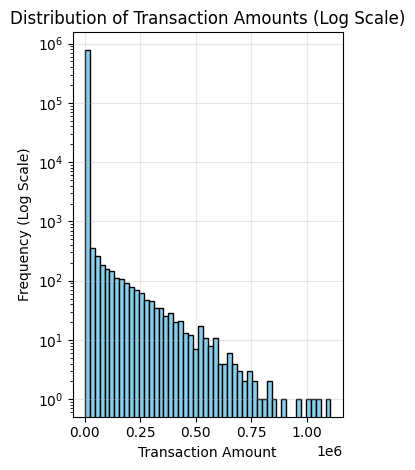

Transaction Amount Distribution Analysis:
Mean transaction amount: $561.75
Median transaction amount: $88.36
Min transaction amount: $0.00
Max transaction amount: $1106070.00
Standard deviation: $11241.37

merchantCategoryCode Analysis:
Total unique categories: 19
Category with highest fraud rate: airline (3.46%)
Category with lowest fraud rate: gym (0.00%)
Average fraud rate across categories: 1.03%
Top 3 categories positively correlated with fraud:
  online_retail: 0.0408
  airline: 0.0214
  online_gifts: 0.0206
Top 3 categories negatively correlated with fraud:
  fuel: -0.0224
  fastfood: -0.0203
  mobileapps: -0.0177

posEntryMode Analysis:
Total unique categories: 5
Category with highest fraud rate: 9.0 (2.39%)
Category with lowest fraud rate: 5.0 (0.78%)
Average fraud rate across categories: 1.68%
Top 3 categories positively correlated with fraud:
  9.0: 0.0428
  2.0: 0.0077
  90.0: 0.0041
Top 3 categories negatively correlated with fraud:
  5.0: -0.0524
  80.0: -0.0001
  90.0: 0

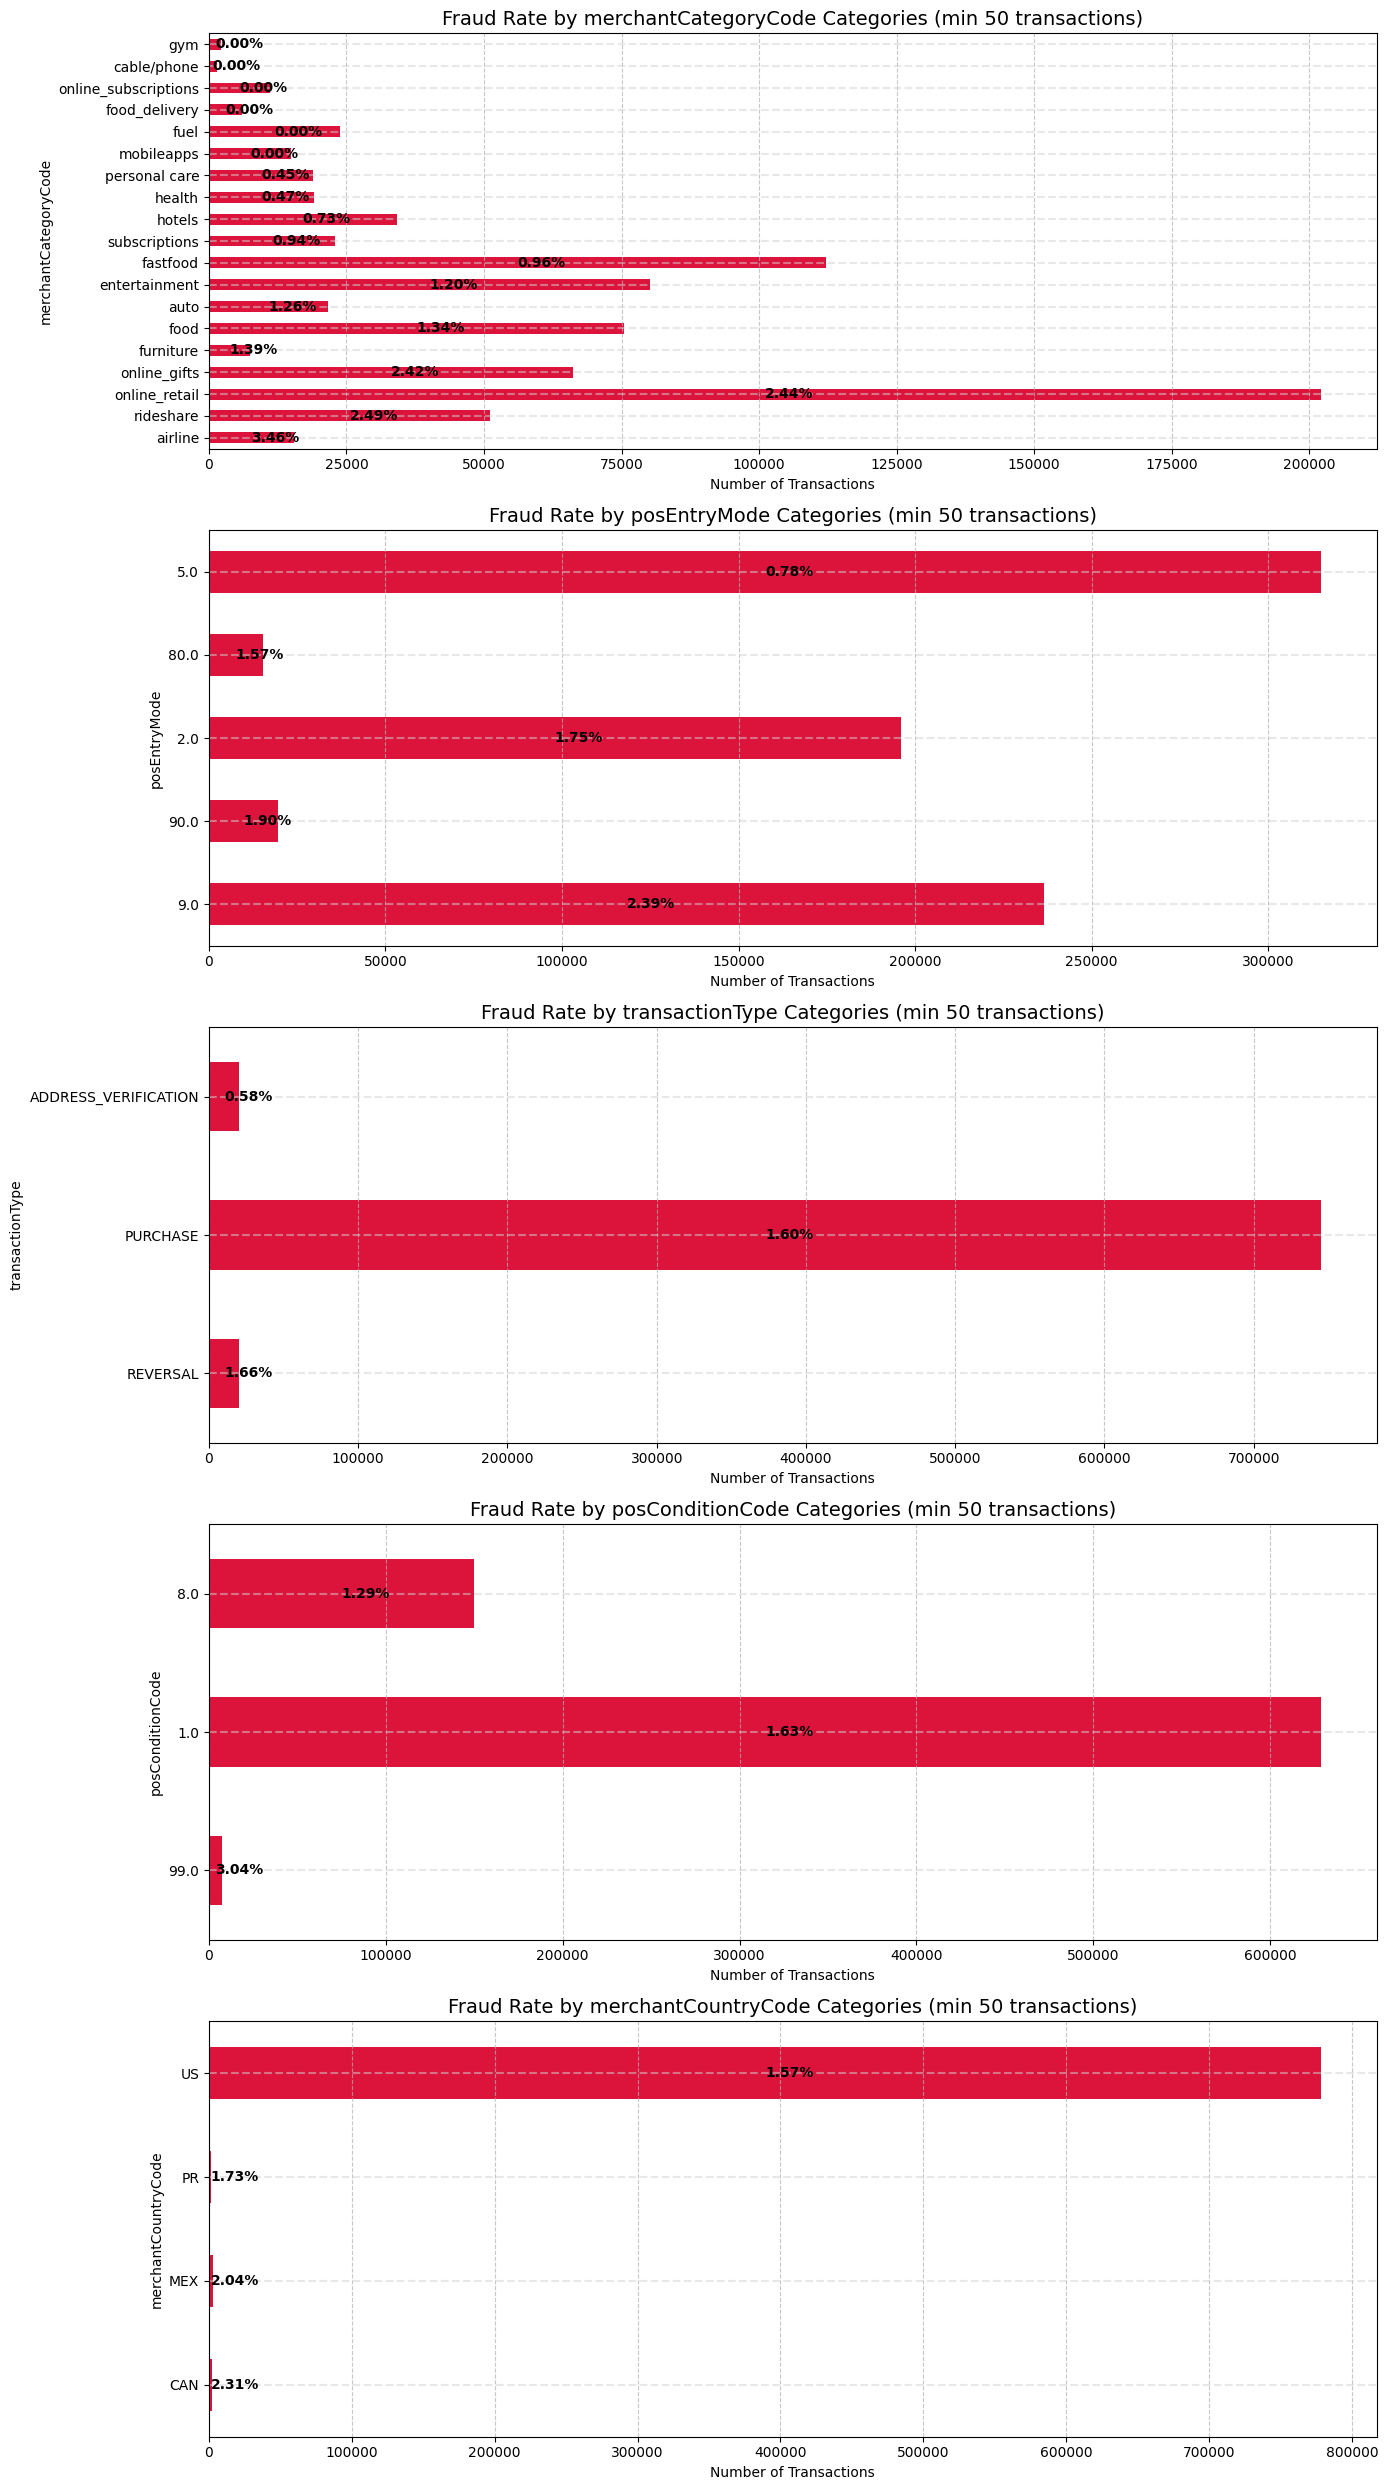

In [59]:

# Log scale for better visualization of the distribution
plt.subplot(1, 2, 2)
plt.hist(df_clean['transactionAmount'], bins=50, color='skyblue', edgecolor='black', log=True)
plt.title('Distribution of Transaction Amounts (Log Scale)')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency (Log Scale)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analysis of the observed pattern
print("Transaction Amount Distribution Analysis:")
print(f"Mean transaction amount: ${df_clean['transactionAmount'].mean():.2f}")
print(f"Median transaction amount: ${df_clean['transactionAmount'].median():.2f}")
print(f"Min transaction amount: ${df_clean['transactionAmount'].min():.2f}")
print(f"Max transaction amount: ${df_clean['transactionAmount'].max():.2f}")
print(f"Standard deviation: ${df_clean['transactionAmount'].std():.2f}")
# Result: large deviation between transaction amoud, and the number decrease with the amount increase

# Relationship between isFraud and categorical predictors
categorical_predictors = ['merchantCategoryCode', 'posEntryMode', 'transactionType', 
                          'posConditionCode', 'merchantCountryCode']

fig, axes = plt.subplots(len(categorical_predictors), 1, figsize=(14, 5*len(categorical_predictors)))

for i, predictor in enumerate(categorical_predictors):
    # Calculate fraud rate by category
    fraud_by_category = df_clean.groupby(predictor)['isFraud'].agg(['count', 'sum', 'mean'])
    fraud_by_category.columns = ['Total_Transactions', 'Fraud_Transactions', 'Fraud_Rate']
    
    # Filter to categories with minimum transaction count for statistical significance
    min_transactions = 50  # Lowered threshold to include more categories
    fraud_by_category = fraud_by_category[fraud_by_category['Total_Transactions'] >= min_transactions]
    
    # Sort by fraud rate
    fraud_by_category = fraud_by_category.sort_values('Fraud_Rate', ascending=False)
    
    # Create bar chart for all categories that meet the minimum threshold
    bars = fraud_by_category['Total_Transactions'].plot(kind='barh', ax=axes[i], color='crimson')
    axes[i].set_title(f'Fraud Rate by {predictor} Categories (min {min_transactions} transactions)', fontsize=14)
    axes[i].set_xlabel('Number of Transactions')
    axes[i].set_ylabel(predictor)
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)
    # Add percentage labels beside the bars black
    for j, (idx, row) in enumerate(fraud_by_category.iterrows()):
        axes[i].axhline(y=j, color='lightgray', linestyle='--', alpha=0.5)
        axes[i].text(row['Total_Transactions']/2, j, f"{row['Fraud_Rate']:.2%}", 
                    va='center', ha='left', color='black', fontweight='bold')
 
    # Print summary statistics
    print(f"\n{predictor} Analysis:")
    print(f"Total unique categories: {fraud_by_category.shape[0]}")
    print(f"Category with highest fraud rate: {fraud_by_category.index[0]} ({fraud_by_category['Fraud_Rate'].iloc[0]:.2%})")
    print(f"Category with lowest fraud rate: {fraud_by_category.index[-1]} ({fraud_by_category['Fraud_Rate'].iloc[-1]:.2%})")
    print(f"Average fraud rate across categories: {fraud_by_category['Fraud_Rate'].mean():.2%}")
    
    # Calculate correlation with fraud (point-biserial for categorical vs binary)
    # Create dummy variables for the categorical predictor
    dummies = pd.get_dummies(df_clean[predictor], prefix=predictor)
    
    # Calculate correlation of each dummy with isFraud
    correlations = dummies.corrwith(df_clean['isFraud'])
    
    # Print top positive and negative correlations
    print(f"Top 3 categories positively correlated with fraud:")
    for cat, corr in correlations.nlargest(3).items():
        
        print(f"  {cat.replace(predictor+'_', '')}: {corr:.4f}")
    
    print(f"Top 3 categories negatively correlated with fraud:")
    for cat, corr in correlations.nsmallest(3).items():
        print(f"  {cat.replace(predictor+'_', '')}: {corr:.4f}")

plt.tight_layout()
plt.show()


                                     mean                      \
transactionType      ADDRESS_VERIFICATION  PURCHASE  REVERSAL   
merchantCategoryCode                                            
airline                          0.020833  0.034488  0.050575   
auto                             0.003322  0.012969  0.010152   
cable/phone                           NaN  0.000000       NaN   
entertainment                    0.010536  0.012001  0.012935   
fastfood                         0.006854  0.009679  0.007909   

                                    count                     
transactionType      ADDRESS_VERIFICATION  PURCHASE REVERSAL  
merchantCategoryCode                                          
airline                             432.0   14527.0    435.0  
auto                                602.0   20433.0    591.0  
cable/phone                           NaN    1382.0      NaN  
entertainment                      2183.0   75575.0   2242.0  
fastfood                           306

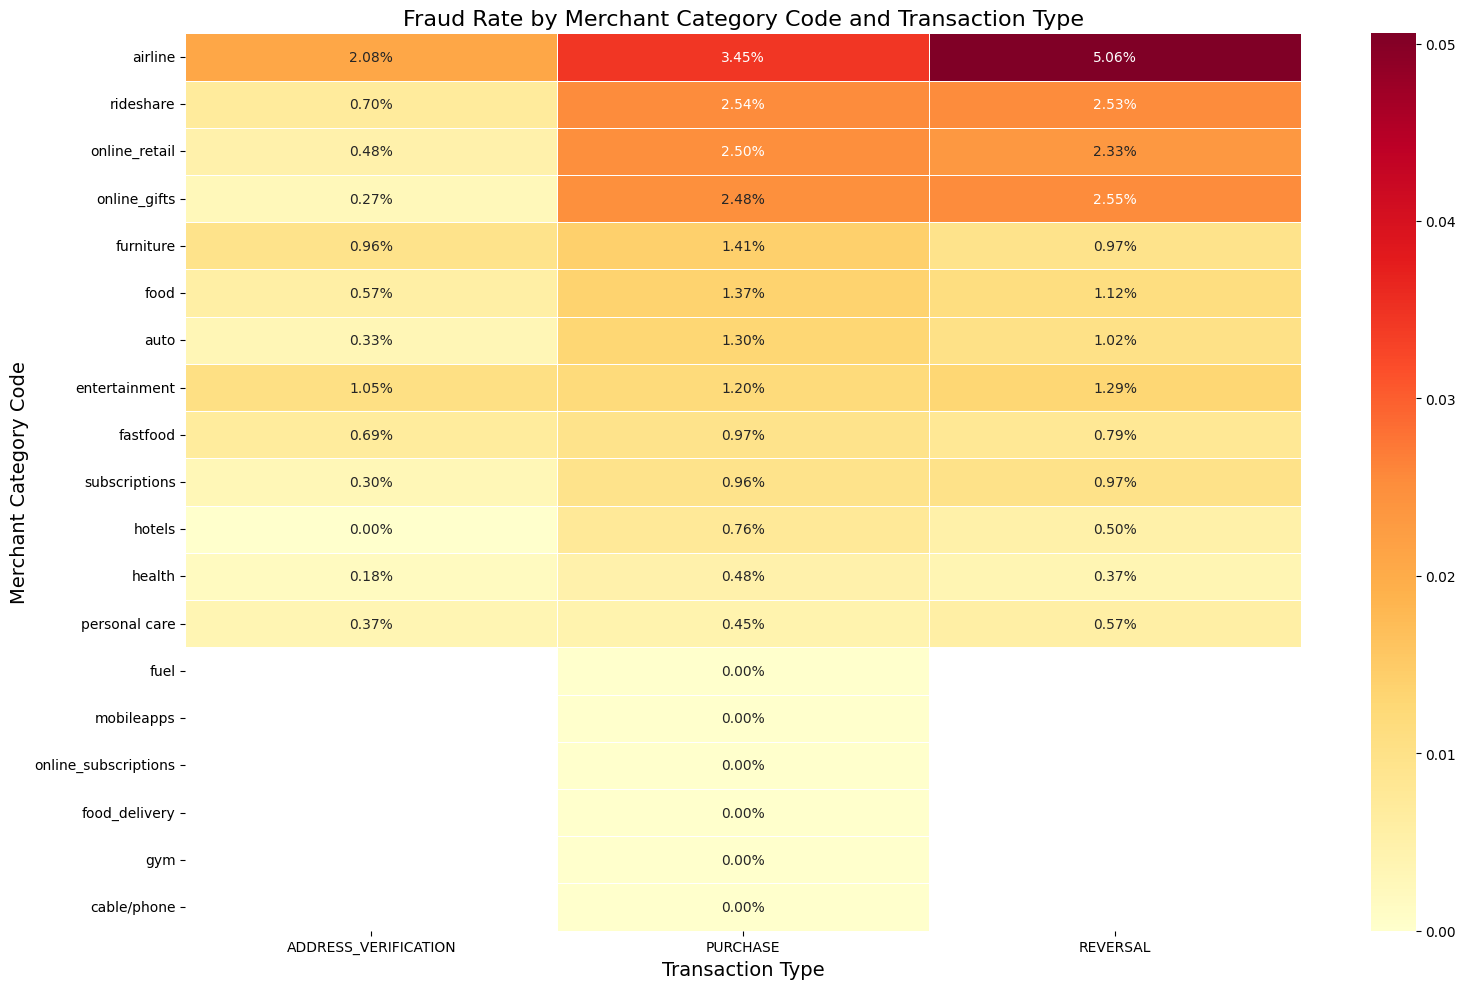

                     ADDRESS_VERIFICATION PURCHASE REVERSAL
merchantCategoryCode                                       
airline                               NaN      NaN      NaN
rideshare                             NaN      NaN      NaN
online_retail                         NaN      NaN      NaN
online_gifts                          NaN      NaN      NaN
furniture                             NaN      NaN      NaN
ADDRESS_VERIFICATION    object
PURCHASE                object
REVERSAL                object
dtype: object


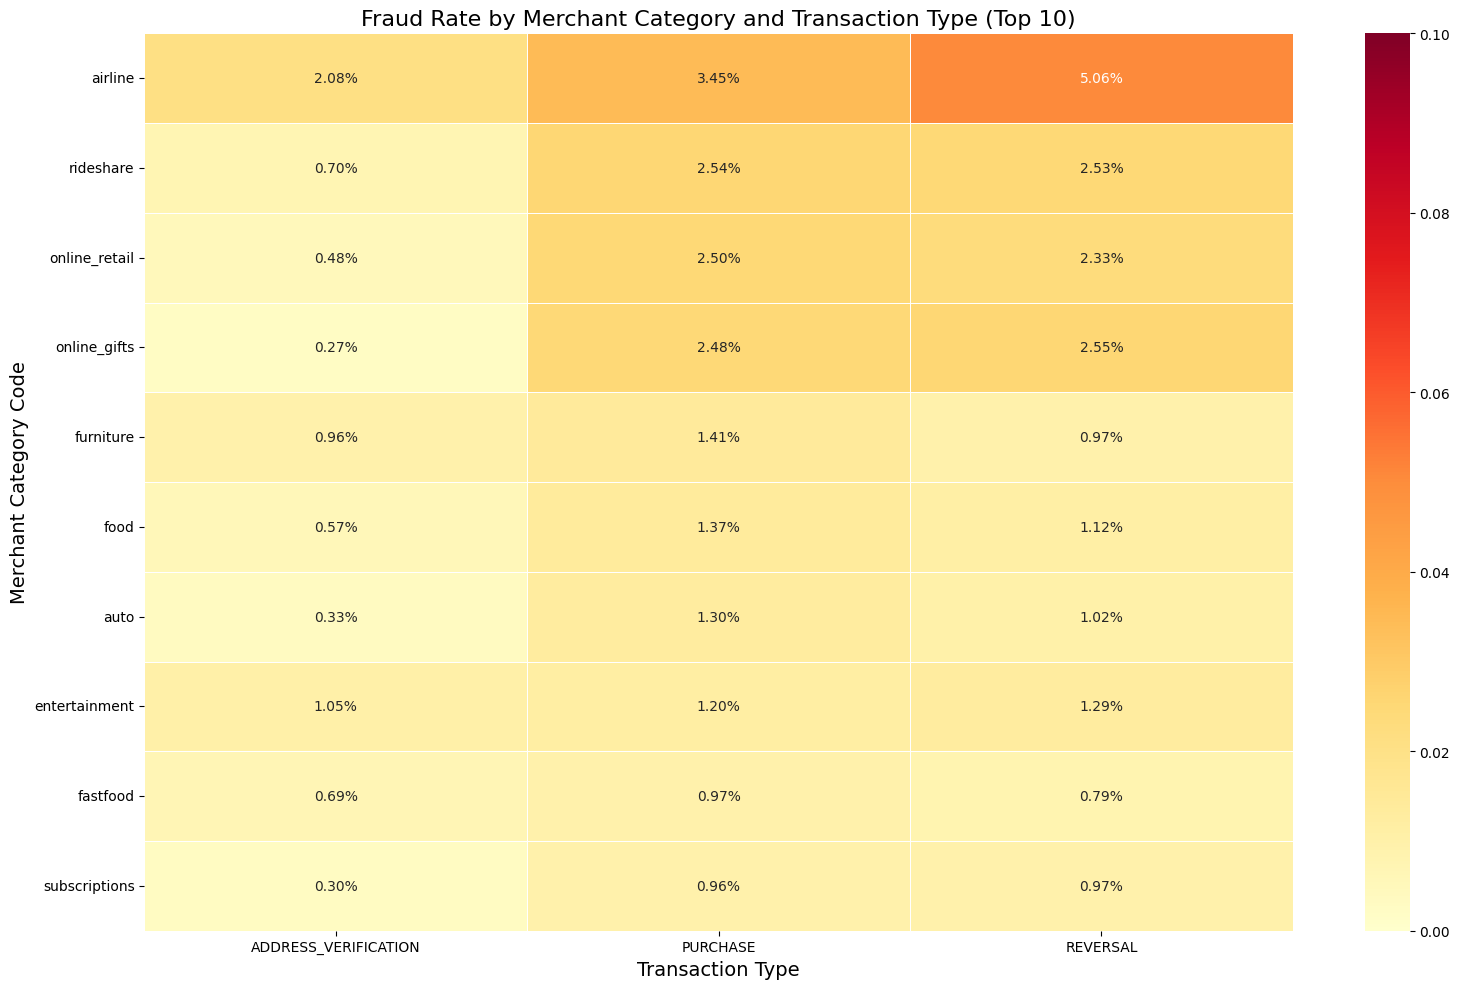

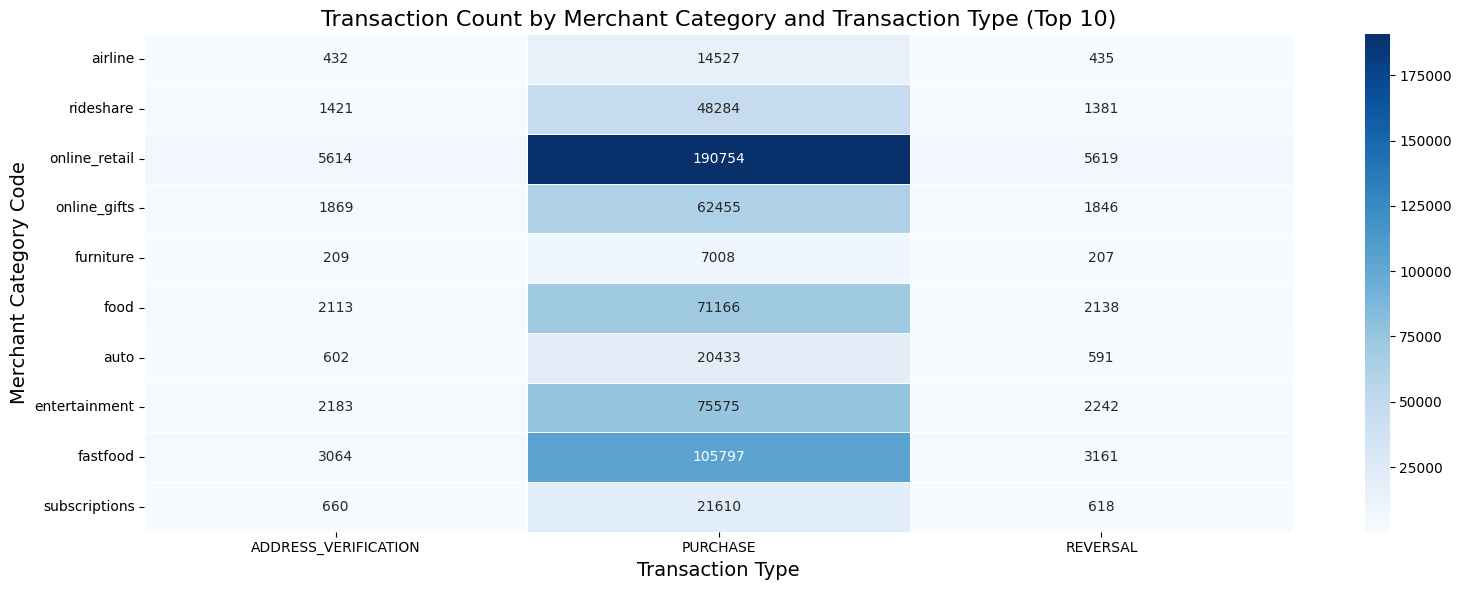

In [60]:
# Relationship between isFraud and transactionType conditioned on merchantCategoryCode
# Get all merchant categories with sufficient data

merchant_categories = df_clean['merchantCategoryCode'].value_counts()
merchant_categories = merchant_categories[merchant_categories >= 100].index.tolist()

# We only consider the merchant categories with at least 100 transactions for statistical significance
# Create a pivot table for fraud rate by merchant category and transaction type

pivot_data = df_clean[df_clean['merchantCategoryCode'].isin(merchant_categories)].pivot_table(
    values='isFraud',
    index='merchantCategoryCode',
    columns='transactionType',
    aggfunc=['mean', 'count']
)
print(pivot_data.head(5))

# Flatten the MultiIndex columns
pivot_data.columns = [f"{col[0]}_{col[1]}" for col in pivot_data.columns]

# Sort by overall fraud rate
overall_fraud_rate = df_clean.groupby('merchantCategoryCode')['isFraud'].mean()
pivot_data = pivot_data.loc[overall_fraud_rate[merchant_categories].sort_values(ascending=False).index]

# Plot the heatmap for fraud rates
plt.figure(figsize=(16, 10))
fraud_rate_cols = [col for col in pivot_data.columns if col.startswith('mean_')]
fraud_rate_data = pivot_data[fraud_rate_cols].copy()
fraud_rate_data.columns = [col.replace('mean_', '') for col in fraud_rate_data.columns]

# Create heatmap
sns.heatmap(fraud_rate_data, annot=True, cmap='YlOrRd', fmt='.2%', linewidths=.5)
plt.title('Fraud Rate by Merchant Category Code and Transaction Type', fontsize=16)
plt.ylabel('Merchant Category Code', fontsize=14)
plt.xlabel('Transaction Type', fontsize=14)
plt.tight_layout()
plt.show()

# Create a heatmap instead of bubble chart for better visualization
plt.figure(figsize=(16, 10))

# Prepare data for heatmap
heatmap_data = pd.DataFrame(index=pivot_data.index[:10], columns=fraud_rate_data.columns)
print(heatmap_data.head())
print(heatmap_data.dtypes)
heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')
# Fill the heatmap data with fraud rates
for merchant in pivot_data.index[:10]:
    for tx_type in fraud_rate_data.columns:
        if f'mean_{tx_type}' in pivot_data.columns:
            fraud_rate = pivot_data.loc[merchant, f'mean_{tx_type}']
            count = pivot_data.loc[merchant, f'count_{tx_type}'] if f'count_{tx_type}' in pivot_data.columns else 0
            if not np.isnan(fraud_rate) and not np.isnan(count) and count > 0:
                heatmap_data.loc[merchant, tx_type] = fraud_rate

# Create the heatmap
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.2%', linewidths=.5, vmin=0, vmax=0.1)

plt.title('Fraud Rate by Merchant Category and Transaction Type (Top 10)', fontsize=16)
plt.ylabel('Merchant Category Code', fontsize=14)
plt.xlabel('Transaction Type', fontsize=14)
plt.tight_layout()
plt.show()

# Display transaction counts in a separate table
plt.figure(figsize=(16, 6))
count_data = pd.DataFrame(index=pivot_data.index[:10], columns=fraud_rate_data.columns)
count_data = count_data.apply(pd.to_numeric, errors='coerce')
for merchant in pivot_data.index[:10]:
    for tx_type in fraud_rate_data.columns:
        if f'count_{tx_type}' in pivot_data.columns:
            count = pivot_data.loc[merchant, f'count_{tx_type}']
            if not np.isnan(count) and count > 0:
                count_data.loc[merchant, tx_type] = count

sns.heatmap(count_data, annot=True, cmap='Blues', fmt='.0f', linewidths=.5)
plt.title('Transaction Count by Merchant Category and Transaction Type (Top 10)', fontsize=16)
plt.ylabel('Merchant Category Code', fontsize=14)
plt.xlabel('Transaction Type', fontsize=14)
plt.tight_layout()
plt.show()


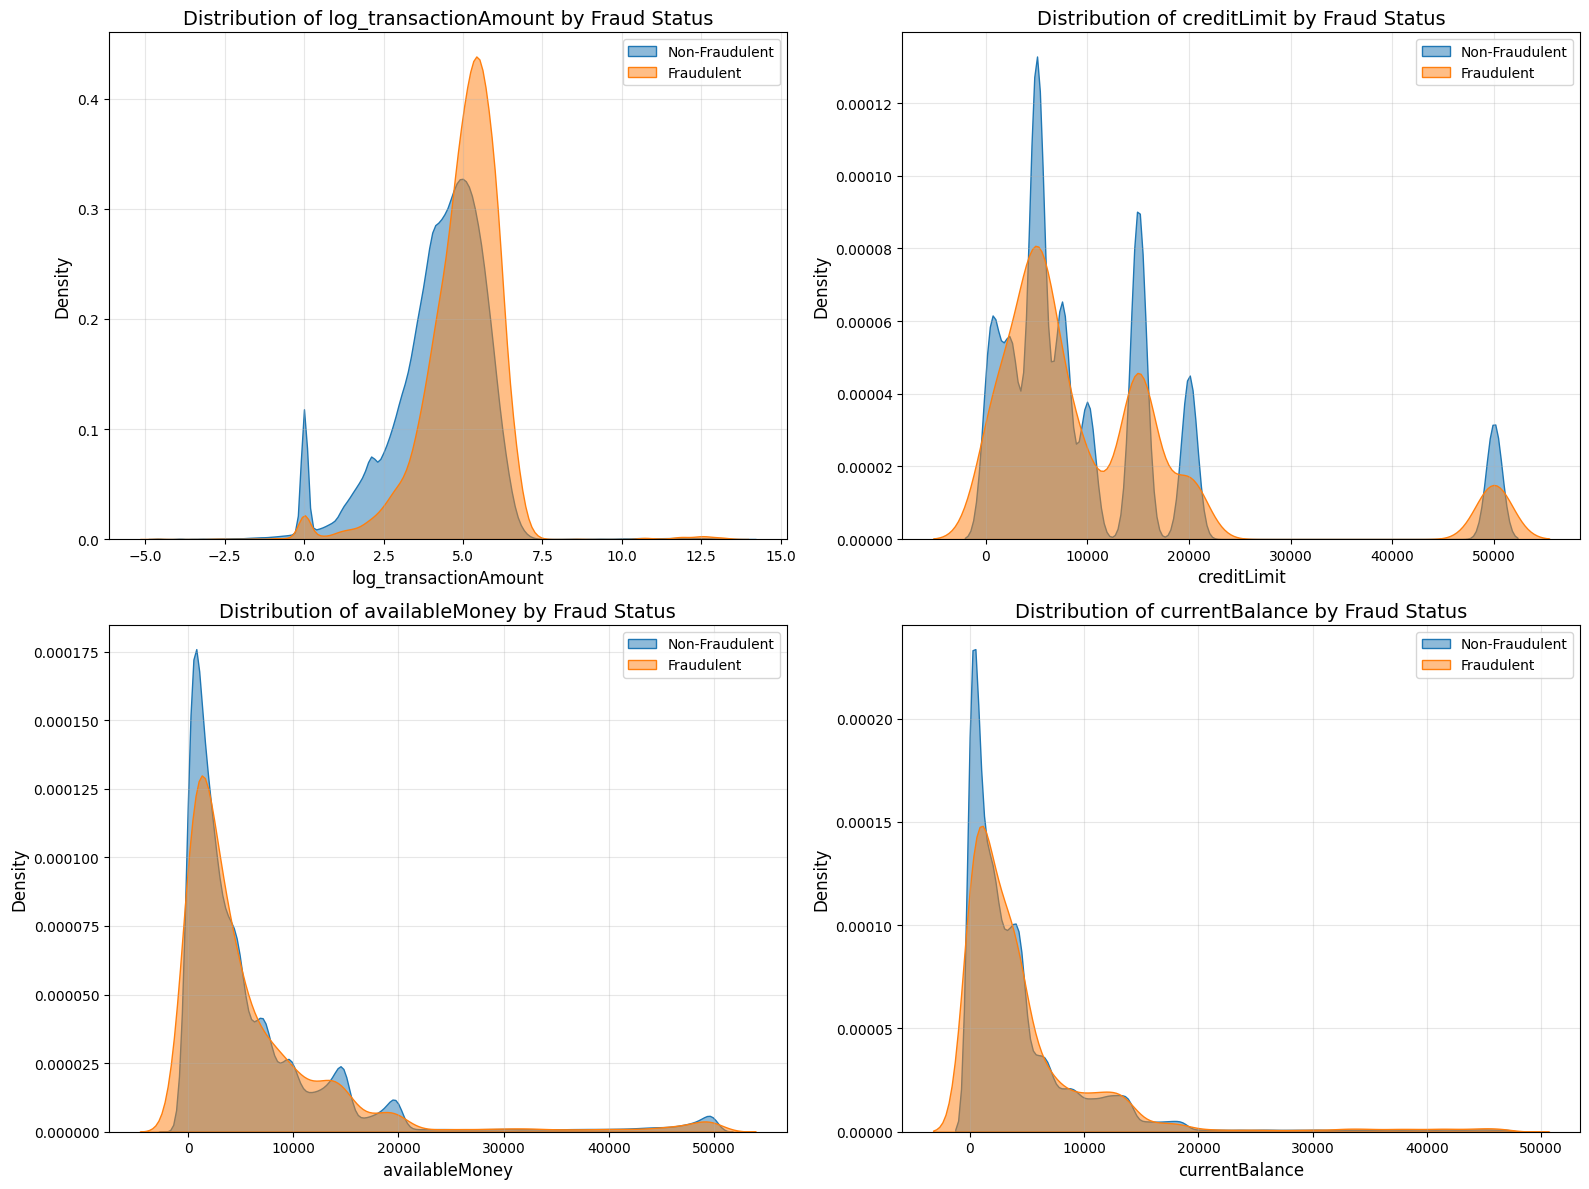


Multi-Swipe Transaction Analysis:
Conditions: Same account, same amount, within 5 minutes
Total transactions: 786363
Multi-swipe transactions: 13297
Percentage of multi-swipe transactions: 1.69%
Percentage of total dollar amount in multi-swipe transactions: 1.80%

Fraud Analysis in Multi-Swipe Transactions:
Fraudulent multi-swipe transactions: 230
Percentage of multi-swipe transactions that are fraudulent: 1.73%
Overall fraud rate in all transactions: 1.58%
Multi-swipe transactions are 1.10x more/less likely to be fraudulent

Class Imbalance Analysis:
Total transactions: 786363
Fraudulent transactions: 12417
Fraud percentage: 1.58%
Imbalance ratio: 1:62


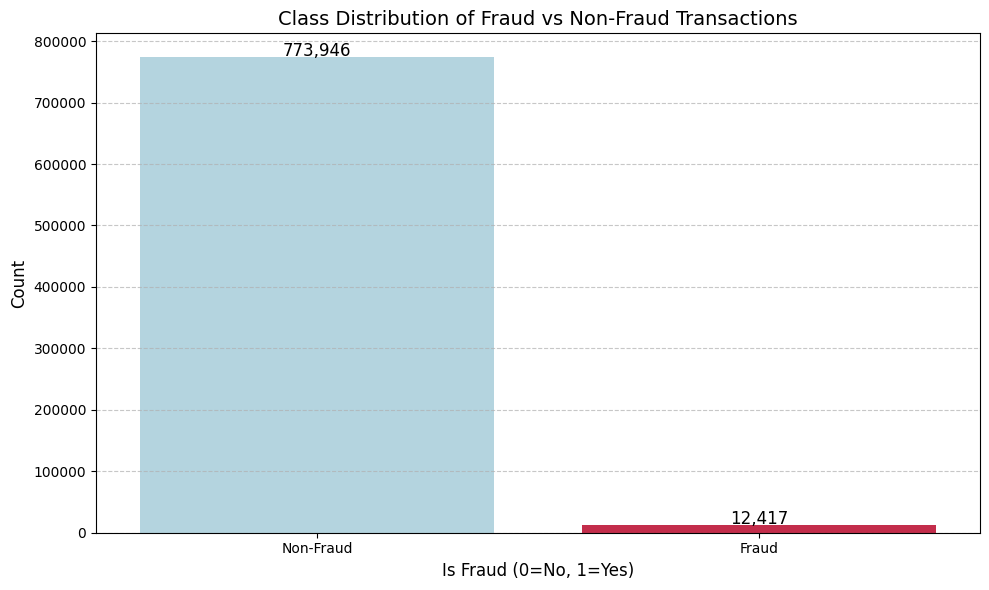


Class Imbalance Mitigation using SMOTE:
Original class distribution: Counter({False: 773946, True: 12417})
Resampled class distribution: Counter({False: 773946, True: 773946})


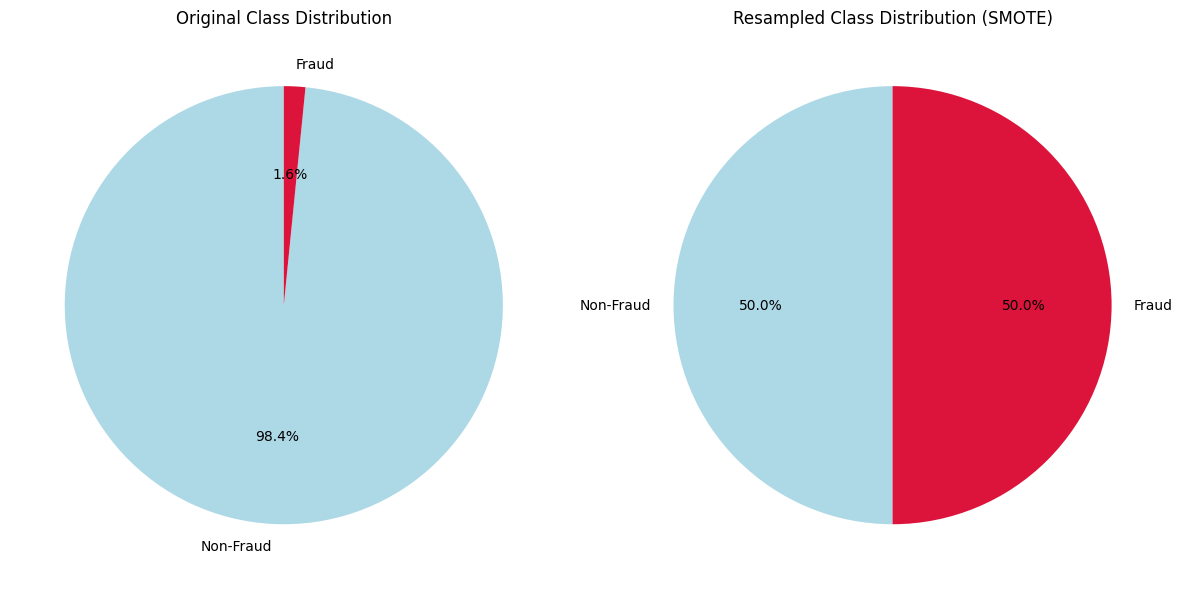

In [77]:

# Conditional probability density plots for numerical variables
numerical_vars = ['log_transactionAmount', 'creditLimit', 'availableMoney', 'currentBalance']
df_clean['log_transactionAmount'] =  df_clean['transactionAmount'].apply(lambda x: np.log(x) if x > 0 else 0)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    # Create KDE plots for fraudulent and non-fraudulent transactions
    sns.kdeplot(data=df_clean[df_clean['isFraud']==False][var], 
                label='Non-Fraudulent', ax=axes[i], fill=True, alpha=0.5)
    sns.kdeplot(data=df_clean[df_clean['isFraud']==True][var], 
                label='Fraudulent', ax=axes[i], fill=True, alpha=0.5)
    
    axes[i].set_title(f'Distribution of {var} by Fraud Status', fontsize=14)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Identifying multi-swipe transactions
# Define conditions: same account, same amount, within 5 minutes, same merchant
df_clean['transactionDateTime'] = pd.to_datetime(df_clean['transactionDateTime'])
df_sorted = df_clean.sort_values(['accountNumber', 'transactionDateTime'])

# Create a time difference column
df_sorted['time_diff'] = df_sorted.groupby('accountNumber')['transactionDateTime'].diff()

# Identify multi-swipe transactions
multi_swipe_conditions = (
    (df_sorted['time_diff'] <= pd.Timedelta(minutes=5)) &  # Within 5 minutes
    (df_sorted['transactionAmount'] == df_sorted['transactionAmount'].shift(1)) &  # Same amount #exclude the first transaction of each account

    (df_sorted['accountNumber'] == df_sorted['accountNumber'].shift(1))  # Same account
)
df_sorted['is_multi_swipe'] = multi_swipe_conditions

# Calculate statistics
total_transactions = len(df_sorted)
multi_swipe_count = df_sorted['is_multi_swipe'].sum()
multi_swipe_percentage = (multi_swipe_count / total_transactions) * 100

total_amount = df_sorted['transactionAmount'].sum()
multi_swipe_amount = df_sorted.loc[df_sorted['is_multi_swipe'], 'transactionAmount'].sum()
multi_swipe_amount_percentage = (multi_swipe_amount / total_amount) * 100

print("\nMulti-Swipe Transaction Analysis:")
print(f"Conditions: Same account, same amount, within 5 minutes")
print(f"Total transactions: {total_transactions}")
print(f"Multi-swipe transactions: {multi_swipe_count}")
print(f"Percentage of multi-swipe transactions: {multi_swipe_percentage:.2f}%")
print(f"Percentage of total dollar amount in multi-swipe transactions: {multi_swipe_amount_percentage:.2f}%")

# Analyze relationship between multi-swipe transactions and fraud
fraud_in_multi_swipe = df_sorted[df_sorted['is_multi_swipe'] & df_sorted['isFraud']].shape[0]
fraud_percentage_in_multi_swipe = (fraud_in_multi_swipe / multi_swipe_count) * 100 if multi_swipe_count > 0 else 0

print("\nFraud Analysis in Multi-Swipe Transactions:")
print(f"Fraudulent multi-swipe transactions: {fraud_in_multi_swipe}")
print(f"Percentage of multi-swipe transactions that are fraudulent: {fraud_percentage_in_multi_swipe:.2f}%")

# Compare with overall fraud rate
overall_fraud_rate = (df_sorted['isFraud'].sum() / total_transactions) * 100
print(f"Overall fraud rate in all transactions: {overall_fraud_rate:.2f}%")
print(f"Multi-swipe transactions are {fraud_percentage_in_multi_swipe/overall_fraud_rate:.2f}x more/less likely to be fraudulent")

# Examine class imbalance
fraud_count = df_clean['isFraud'].sum()
total_count = len(df_clean)
fraud_percentage = (fraud_count / total_count) * 100

print("\nClass Imbalance Analysis:")
print(f"Total transactions: {total_count}")
print(f"Fraudulent transactions: {fraud_count}")
print(f"Fraud percentage: {fraud_percentage:.2f}%")
print(f"Imbalance ratio: 1:{(total_count - fraud_count) / fraud_count:.0f}")

# Visualize class imbalance
plt.figure(figsize=(10, 6))
sns.countplot(x='isFraud', data=df_clean, palette=['lightblue', 'crimson'])
plt.title('Class Distribution of Fraud vs Non-Fraud Transactions', fontsize=14)
plt.xlabel('Is Fraud (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels
for i, count in enumerate(df_clean['isFraud'].value_counts()):
    plt.text(i, count + 1000, f'{count:,}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Implement a method to mitigate class imbalance - SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

# Select features for demonstration 
X = df_clean[['transactionAmount', 'creditLimit', 'availableMoney', 'currentBalance']]
y = df_clean['isFraud']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Compare class distributions
original_distribution = Counter(y)
resampled_distribution = Counter(y_resampled)

print("\nClass Imbalance Mitigation using SMOTE:")
print(f"Original class distribution: {original_distribution}")
print(f"Resampled class distribution: {resampled_distribution}")

# Visualize the effect of SMOTE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie([original_distribution[0], original_distribution[1]], 
        labels=['Non-Fraud', 'Fraud'], 
        autopct='%1.1f%%', 
        colors=['lightblue', 'crimson'],
        startangle=90)
plt.title('Original Class Distribution')

plt.subplot(1, 2, 2)
plt.pie([resampled_distribution[0], resampled_distribution[1]], 
        labels=['Non-Fraud', 'Fraud'], 
        autopct='%1.1f%%', 
        colors=['lightblue', 'crimson'],
        startangle=90)
plt.title('Resampled Class Distribution (SMOTE)')

plt.tight_layout()
plt.show()
